### Generative Advesarial Network (GAN)

In this notebook we will generate `Watermelons` using a `DCGAN`.

### Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds
import os, PIL, time, tqdm
from tensorflow.keras.preprocessing import image, image_dataset_from_directory
print(tf.__version__)

2.5.0


In [2]:
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)

### Data Preparation.

In this notebook we are going to use the `fruit-360` dataset. But we will be interested on one fruit in our case a `watermelon`. I've already uploaded the images on my google drive.

In [3]:
from google.colab import drive
drive.mount('/content/drive')
print("Mounted")

Mounted at /content/drive
Mounted


### Hyper parameters

In [13]:
DATA_PATH = '/content/drive/MyDrive/Computer Vision/Watermelon-Images'
EPOCHS = 50
BATCH_SIZE = 32
BUFFER_SIZE = 1500
SEED_SIZE = 100
IMAGE_CHANNELS = 3
GENERATE_RES = 3
GENERATE_SQUARE = 32 * GENERATE_RES
PREVIEW_ROWS = 4
PREVIEW_COLS = 7
PREVIEW_MARGIN = 16

In [14]:
os.path.exists(DATA_PATH)

True

In [15]:
datagen = image.ImageDataGenerator(
    rescale=1.0 / 255,
    data_format = "channels_last",
    dtype = tf.float32,
)

In [16]:
train_dataset = datagen.flow_from_directory(
    DATA_PATH,
    target_size=(GENERATE_SQUARE, GENERATE_SQUARE),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    interpolation='nearest',
)

Found 475 images belonging to 1 classes.


### Reading images Only from the dataset.

We are doing this because we want to create tensor slices, so that we will be able to create a dataset later on that we will be using to train our end to end GAN.

In [17]:
def create_image_tensors(): 
  images = []
  start = time.time()
  for batch in train_dataset:
    start_batch = time.time()
    print(f"Images found {len(batch[0])}")
    for image in batch[0]:
      images.append(image)
    print(f"Done appending {len(batch[0])}, ETA: { time.time() - start}")
    print(f"Now we have {len(images)} image(s)")
    if (len(images) >= 10000):
      break
  print(f"ETA: { hms_string(time.time() -start)}")
  return images

### Saving the picke file

Since the previous operation can takes a lot of time we can save images in numpy binary format by calling `np.save()` function.

In [19]:
training_binary_path = os.path.join(DATA_PATH, f'training_data_{GENERATE_SQUARE}_{GENERATE_SQUARE}.npy')
if os.path.exists(training_binary_path):
  print("Loading the esisting pickle")
  training_data = np.load(training_binary_path)
else:
  images = create_image_tensors()
  np.save(training_binary_path, images, allow_pickle=True)
  training_data = np.load(training_binary_path)
print("Loaded")

Images found 32
Done appending 32, ETA: 10.138283967971802
Now we have 32 image(s)
Images found 32
Done appending 32, ETA: 18.5920193195343
Now we have 64 image(s)
Images found 32
Done appending 32, ETA: 26.48620295524597
Now we have 96 image(s)
Images found 32
Done appending 32, ETA: 35.396615743637085
Now we have 128 image(s)
Images found 32
Done appending 32, ETA: 43.91461801528931
Now we have 160 image(s)
Images found 32
Done appending 32, ETA: 52.17463183403015
Now we have 192 image(s)
Images found 32
Done appending 32, ETA: 60.15358018875122
Now we have 224 image(s)
Images found 32
Done appending 32, ETA: 68.10827922821045
Now we have 256 image(s)
Images found 32
Done appending 32, ETA: 76.04779696464539
Now we have 288 image(s)
Images found 32
Done appending 32, ETA: 83.63891053199768
Now we have 320 image(s)
Images found 32
Done appending 32, ETA: 91.27370381355286
Now we have 352 image(s)
Images found 32
Done appending 32, ETA: 99.17705011367798
Now we have 384 image(s)
Images

### Creating dataset from tensor slices.

In [20]:
train_ds = tf.data.Dataset.from_tensor_slices(training_data).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [21]:
for batch in train_ds:
  break

### Plotting Real Images from the dataset.

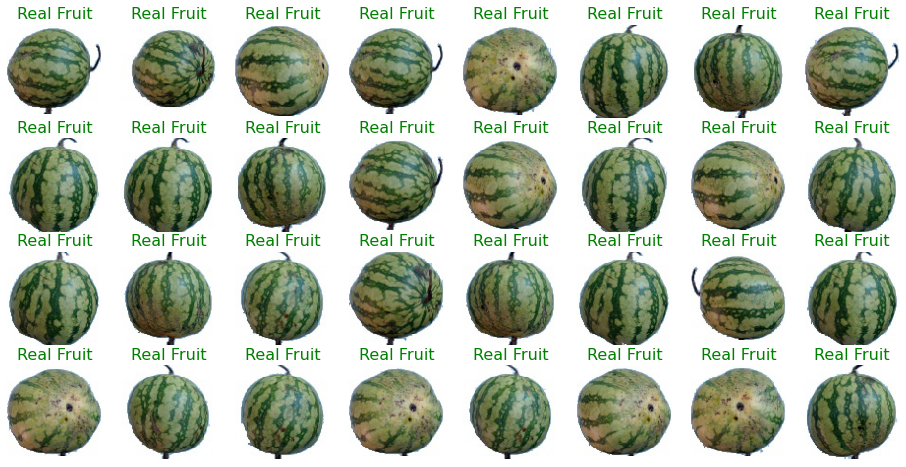

In [22]:
def plot_images(images_and_classes, cols=5):
    rows = 4
    fig = plt.figure()
    fig.set_size_inches(cols * 2, rows * 2)
    for i, (image) in enumerate(images_and_classes):
        plt.subplot(rows, cols, i + 1)
        plt.axis('off')
        plt.imshow(image, cmap="gray")
        plt.title("Real Fruit", color ='g', fontsize=16 )

plot_images(batch[:], cols=8)

### The generator Model.
We are going to build the generator model using subclassing approach on blocks of layers. From the faces generator model we used the `UpSampling2D()` together with the `Conv2D` during the creation of our `GBlock`. In this notebook we are going to use the `Conv2DTranspose()` together with  `UpSampling2D()` and `Conv2D` layers.

In [54]:
class GBlock(keras.layers.Layer):
  def __init__(self, in_features, kernel_size=3, activation="relu", momentum=0.8, 
               padding="same", strides=(2, 2), sampling_size=None):
    super(GBlock, self).__init__()

    self.sampling_size = sampling_size

    if sampling_size:
      self.up_sampler = keras.layers.UpSampling2D(size=sampling_size)
      self.conv = keras.layers.Conv2D(in_features, kernel_size=kernel_size, padding=padding)
    else:
      self.conv = keras.layers.Conv2DTranspose(in_features, kernel_size=kernel_size, padding=padding, strides=strides)
    self.bn = keras.layers.BatchNormalization(momentum=momentum)
    self.relu = keras.layers.ReLU()

  def call(self, x):
    if self.sampling_size:
      x = self.up_sampler(x)
    x = self.conv(x)
    x = self.bn(x)
    return self.relu(x)

class OutputBlock(keras.layers.Layer):
  def __init__(self,channels, kernel_size=3,padding="same"):
    super(OutputBlock, self).__init__()
    self.conv = keras.layers.Conv2D(channels,kernel_size=kernel_size,padding=padding)
    self.tanh = keras.activations.tanh
  def call(self, x):
    x = self.conv(x)
    return self.tanh(x)

    

In [55]:
def build_generator(seed_size, channels):
  model = keras.Sequential([
      keras.layers.Dense(4*4*256,activation="relu",input_dim=seed_size),
      keras.layers.Reshape((4,4,256)),
      GBlock(256),
      GBlock(256),
      GBlock(128),          
  ], name="generator")
  if GENERATE_RES > 1:
    model.add(GBlock(128, sampling_size=(GENERATE_RES,GENERATE_RES)))
  model.add(OutputBlock(3))
  return model
build_generator(SEED_SIZE, 3).summary()

Model: "generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 4096)              413696    
_________________________________________________________________
reshape_7 (Reshape)          (None, 4, 4, 256)         0         
_________________________________________________________________
g_block_28 (GBlock)          (None, 8, 8, 256)         591104    
_________________________________________________________________
g_block_29 (GBlock)          (None, 16, 16, 256)       591104    
_________________________________________________________________
g_block_30 (GBlock)          (None, 32, 32, 128)       295552    
_________________________________________________________________
g_block_31 (GBlock)          (None, 96, 96, 128)       148096    
_________________________________________________________________
output_block_4 (OutputBlock) (None, 96, 96, 3)         34

### The discriminator model.

We are going to build the discriminator model using subclassing approach on blocks of layers

In [56]:
class DBlock(keras.layers.Layer):
  def __init__(self, in_features, kernel_size=3, strides=2, padding="same",
               zero_padding_2d=False, dropout= .25, momentum=.8):
    super().__init__()
    self.zero_padding_2d = zero_padding_2d
    self.dropout = keras.layers.Dropout(dropout)
    self.conv = keras.layers.Conv2D(in_features, kernel_size=kernel_size, padding=padding, strides = strides)
    self.zero_padding = keras.layers.ZeroPadding2D(padding=((0,1),(0,1)))
    self.bn = keras.layers.BatchNormalization(momentum=momentum)
    self.leaky_relu = keras.layers.LeakyReLU(alpha=.2)

  def call(self, x):
    x = self.dropout(x)
    x = self.conv(x)
    if self.zero_padding_2d:
      x = self.zero_padding(x)
    x = self.bn(x)
    return self.leaky_relu(x)

class DOutputBlock(keras.layers.Layer):
  def __init__(self, dropout=.25):
    super().__init__(self)
    self.dropout = keras.layers.Dropout(dropout)
    self.flatten = keras.layers.Flatten()
    self.output_layer = keras.layers.Dense(1, activation='sigmoid')
    
  def call(self, x):
    x = self.dropout(x)
    x = self.flatten(x)
    return self.output_layer(x)


In [57]:
def build_discriminator(image_shape):
  model = keras.Sequential([
          keras.layers.Conv2D(32, kernel_size=3, strides=2, input_shape=image_shape, 
                     padding="same"),
          keras.layers.LeakyReLU(alpha=0.2),
          DBlock(64, zero_padding_2d=True),
          DBlock(128),
          DBlock(256),
          DBlock(512),
          DOutputBlock()
  ], name="discriminator")
  return model
image_shape = (GENERATE_SQUARE,GENERATE_SQUARE,IMAGE_CHANNELS)
build_discriminator(image_shape).summary()

Model: "discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_25 (Conv2D)           (None, 48, 48, 32)        896       
_________________________________________________________________
leaky_re_lu_10 (LeakyReLU)   (None, 48, 48, 32)        0         
_________________________________________________________________
d_block_8 (DBlock)           (None, 25, 25, 64)        18752     
_________________________________________________________________
d_block_9 (DBlock)           (None, 13, 13, 128)       74368     
_________________________________________________________________
d_block_10 (DBlock)          (None, 7, 7, 256)         296192    
_________________________________________________________________
d_block_11 (DBlock)          (None, 4, 4, 512)         1182208   
_________________________________________________________________
d_output_block_2 (DOutputBlo (None, 1)               

### Generating a Single Image before trainning

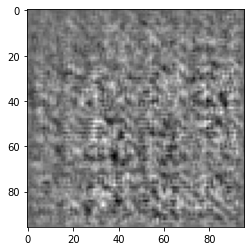

In [58]:
generator = build_generator(SEED_SIZE, IMAGE_CHANNELS)
noise = tf.random.normal([1, SEED_SIZE])
generated_image = generator(noise, training=False)
plt.imshow(generated_image[0, :, :, 0], cmap="gray")
plt.show()

### Detemining if the generated image is real or fake using the discriminator model before training

In [59]:
image_shape = (GENERATE_SQUARE,GENERATE_SQUARE,IMAGE_CHANNELS)
discriminator = build_discriminator(image_shape)
discriminator(generated_image)

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.5000604]], dtype=float32)>

### Loss Functions.
For more on this please visit the `Face Generator` notebook.

In [60]:
cross_entropy = keras.losses.BinaryCrossentropy()

def discriminator_loss(real_output, fake_output):
  real_loss = cross_entropy(tf.ones_like(real_output), real_output)
  fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
  return real_loss + fake_loss

def generator_loss(fake_output):
  fake_loss = cross_entropy(tf.ones_like(fake_output), fake_output)
  return fake_loss

### Optimizers.
Both the generator and the discriminator will have the same optimizer.

In [61]:
generator_optimizer = tf.keras.optimizers.Adam(1.5e-4,0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(1.5e-4,0.5)

### Train step function.

In [62]:
@tf.function
def train_step(images):
  seed = tf.random.normal((BATCH_SIZE, SEED_SIZE))

  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_images = generator(seed, training=True)
    
    real_output = discriminator(images, training=True)
    fake_output = discriminator(generated_images, training=True)

    gen_loss = generator_loss(fake_output)
    disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(
        gradients_of_generator, generator.trainable_variables
    ))
    discriminator_optimizer.apply_gradients(zip(
        gradients_of_discriminator, discriminator.trainable_variables
    ))
      
  return gen_loss, disc_loss

### Function that saves images

In [63]:
from PIL import Image

def save_images(cnt,noise):
  image_array = np.full(( 
      PREVIEW_MARGIN + (PREVIEW_ROWS * (GENERATE_SQUARE+PREVIEW_MARGIN)), 
      PREVIEW_MARGIN + (PREVIEW_COLS * (GENERATE_SQUARE+PREVIEW_MARGIN)), 3), 
      255, dtype=np.uint8)
  generated_images = generator.predict(noise)
  generated_images = 0.5 * generated_images + 0.5
  image_count = 0
  for row in range(PREVIEW_ROWS):
      for col in range(PREVIEW_COLS):
        r = row * (GENERATE_SQUARE+16) + PREVIEW_MARGIN
        c = col * (GENERATE_SQUARE+16) + PREVIEW_MARGIN
        image_array[r:r+GENERATE_SQUARE,c:c+GENERATE_SQUARE] \
            = generated_images[image_count] * 255
        image_count += 1

          
  output_path = os.path.join(DATA_PATH,'output')
  if not os.path.exists(output_path):
    os.makedirs(output_path)
  
  filename = os.path.join(output_path,f"train-{cnt}.png")
  im = Image.fromarray(image_array)
  im.save(filename)

### The Train function
In this function we are going to use a fixed_seed to get reliable results.

In [64]:
def train(dataset, epochs):
  fixed_seed = np.random.normal(0, 1, (
      PREVIEW_ROWS * PREVIEW_COLS, SEED_SIZE
  ))
  start = time.time()

  for epoch in range(epochs):
    epoch_start = time.time()

    gen_loss_list = []
    disc_loss_list = []
    for image_batch in dataset:
      gen_loss, disc_loss = train_step(image_batch)
      gen_loss_list.append(gen_loss)
      disc_loss_list.append(disc_loss)

    g_loss = sum(gen_loss_list)/len(gen_loss_list)
    d_loss = sum(disc_loss_list)/len(disc_loss_list)

    epoch_elapsed = time.time() - epoch_start
    print (f'Epoch {epoch+1} [ gen loss:{g_loss}] [disc loss: {d_loss}] || time: {hms_string(epoch_elapsed)}')
    save_images(epoch, fixed_seed)
    
  elapsed = time.time() - start
  print (f'Training time: {hms_string(elapsed)}')

### Training the model.

In [65]:
train(train_ds, EPOCHS)

Epoch 1 [ gen loss:5.706575870513916] [disc loss: 0.30581822991371155] || time: 0:00:31.83
Epoch 2 [ gen loss:10.757750511169434] [disc loss: 0.3740842640399933] || time: 0:00:29.04
Epoch 3 [ gen loss:5.262741565704346] [disc loss: 0.5061294436454773] || time: 0:00:29.23
Epoch 4 [ gen loss:3.492532968521118] [disc loss: 0.3910081088542938] || time: 0:00:29.53
Epoch 5 [ gen loss:3.5701117515563965] [disc loss: 0.22853520512580872] || time: 0:00:29.73
Epoch 6 [ gen loss:3.101844549179077] [disc loss: 0.3847959339618683] || time: 0:00:29.91
Epoch 7 [ gen loss:3.2110798358917236] [disc loss: 0.39863190054893494] || time: 0:00:30.07
Epoch 8 [ gen loss:3.0758514404296875] [disc loss: 0.3836706280708313] || time: 0:00:30.18
Epoch 9 [ gen loss:3.2858831882476807] [disc loss: 0.3267545998096466] || time: 0:00:30.23
Epoch 10 [ gen loss:3.481381416320801] [disc loss: 0.294159471988678] || time: 0:00:30.32
Epoch 11 [ gen loss:3.43137264251709] [disc loss: 0.287911057472229] || time: 0:00:30.26
Epo

### Generating some Watermelons

In [66]:
seeds = tf.random.normal([32, SEED_SIZE])
generated_image = generator(seeds, training=False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

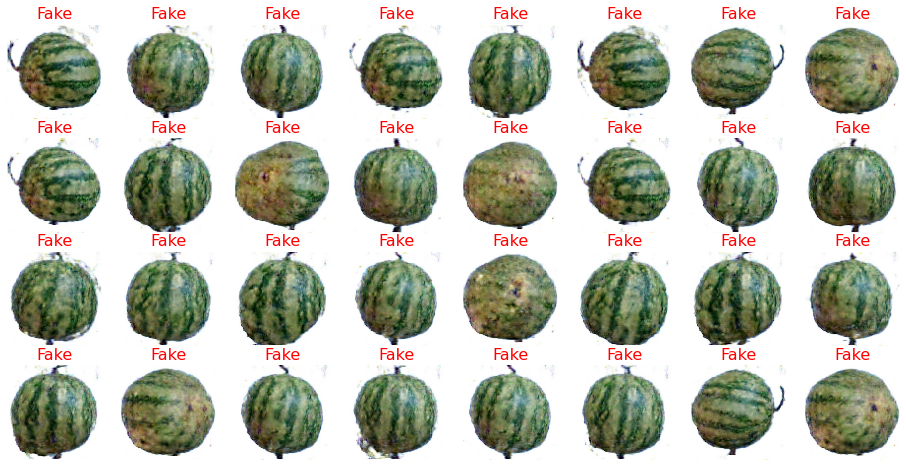

In [68]:
def plot_images(images_and_classes, cols=5):
    rows = 4
    fig = plt.figure()
    fig.set_size_inches(cols * 2, rows * 2)
    for i, (image) in enumerate(images_and_classes):
        plt.subplot(rows, cols, i + 1)
        plt.axis('off')
        plt.imshow(np.array(image.numpy() * 255,np.int32) , cmap="gray")
        plt.title("Fake", color ='r', fontsize=16 )

plot_images(generated_image[:], cols=8)